**Homework**

1.   Get sudoku dataset from: [kaggle](https://www.kaggle.com/bryanpark/sudoku)
2.   Train a Sudoku Solver with *linear layers* , in Pytorch :)

Of course, for the full mark on this homework you aren't expected to achieve state-of-the-art performance with this model.

You should:

*   Get data in pytorch-friendly format.
*   Formulate a loss function for this problem.
*   Create a model that is able to learn with the proposed loss function.
*   Observe train/validation error; train-error should steadly decrease
*   (optional) Wire the network in a way that makes learning easier.


In [0]:
import torch

In [0]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [7]:
from google.colab import drive
drive.mount('/content/gdrive')
FILE_PATH ='/content/gdrive/My Drive/Colab Notebooks/Homework#1/sudoku.csv'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
#read sudoku.csv
import numpy as np
quizzes = np.zeros((1000000, 81), np.int32)
solutions = np.zeros((1000000, 81), np.int32)
for i, line in enumerate(open(FILE_PATH, 'r').read().splitlines()[1:]):
  quiz, solution = line.split(",")
  for j, q_s in enumerate(zip(quiz, solution)):
    q, s = q_s
    quizzes[i, j] = int(q)
    solutions[i, j] = int(s)
quizzes = quizzes.reshape((-1, 9, 9))
solutions = solutions.reshape((-1, 9, 9))

In [0]:
np.save('/content/gdrive/My Drive/Colab Notebooks/Homework#1/quizzes.npy', quizzes)
np.save('/content/gdrive/My Drive/Colab Notebooks/Homework#1/solutions.npy', solutions)

In [0]:
quizzes = np.load('/content/gdrive/My Drive/Colab Notebooks/Homework#1/quizzes.npy')
solutions = np.load('/content/gdrive/My Drive/Colab Notebooks/Homework#1/solutions.npy')
quizzes = torch.Tensor(quizzes).cuda()
solutions = torch.Tensor(solutions).cuda()

In [0]:
print(quizzes)
print(solutions)

In [0]:
print(quizzes.shape)
print(solutions.shape)

In [11]:
quizzesVetorize = torch.squeeze(quizzes.reshape((-1, 81, 1)))
solutionsVetorize = torch.squeeze(solutions.reshape((-1, 81, 1)))
print(quizzesVetorize.shape)
print(solutionsVetorize.shape)

torch.Size([1000000, 81])
torch.Size([1000000, 81])


In [0]:
randPerm = torch.randperm((quizzesVetorize.shape)[0])
quizzesVetorizeRand = quizzesVetorize[randPerm][:]
solutionsVetorizeRand = solutionsVetorize[randPerm][:]

In [13]:
import math

train_size = math.floor(0.3 * (quizzesVetorizeRand.shape)[0])
val_size = math.floor(0.05 * (quizzesVetorizeRand.shape)[0])
test_size = math.floor(0.01 * (quizzesVetorizeRand.shape)[0])
train_data = quizzesVetorizeRand[0:train_size][:]
train_labels = solutionsVetorizeRand[0:train_size][:]
val_data = quizzesVetorizeRand[train_size:train_size + val_size][:]
val_labels = solutionsVetorizeRand[train_size:train_size + val_size][:]
test_data = quizzesVetorizeRand[train_size + val_size : train_size + val_size + test_size][:]
test_labels = solutionsVetorizeRand[train_size + val_size : train_size + val_size + test_size][:]
print(train_size)
print(val_size)
print(test_size)
print(train_data.shape)
print(train_labels.shape)
print(val_data.shape)
print(val_labels.shape)
print(test_data.shape)
print(test_labels.shape)
train_data = train_data.cuda()
train_labels = train_labels.cuda()
val_data = val_data.cuda()
val_labels = val_labels.cuda()
test_data = test_data.cuda()
test_labels = test_labels.cuda()

300000
50000
10000
torch.Size([300000, 81])
torch.Size([300000, 81])
torch.Size([50000, 81])
torch.Size([50000, 81])
torch.Size([10000, 81])
torch.Size([10000, 81])


In [0]:
import matplotlib.pyplot as plt

def plot_loss(loss, label, color='blue'):
    plt.plot(loss, label=label, color=color)
    plt.legend()

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    # nn.Module - base class for all models
    # easy acces to .parameters() and .zero_grad()
    # define .forward() instead of __call__()
    
    def __init__(self, in_size, h_size1, h_size2, out_size):
        super().__init__()
        self._layer1 = nn.Linear(in_size,h_size1).cuda()
        self._layer2 = nn.Linear(h_size1,h_size2).cuda()
        self._layer3 = nn.Linear(h_size2,out_size).cuda()
        
    def forward(self, x):
        x = F.relu(self._layer1(x)).cuda()
        x = F.relu(self._layer2(x)).cuda()
        x = self._layer3(x).cuda()
        return x.cuda()
        
    def train(self, train_data, train_labels, 
              epochs=400, lr=0.01, verbose=100, l2_weight=0,
              val_data=None, val_labels=None):
        #use optimizers to take care of the update step
        optimizer1 = torch.optim.SGD(self.parameters(), lr=lr,
                               weight_decay = l2_weight)
        
        optimizer2 = torch.optim.Adagrad(self.parameters())
        optimizer3 = torch.optim.RMSprop(self.parameters())
        optimizer4 = torch.optim.Adam(self.parameters())
        
        criterion = nn.CrossEntropyLoss();
        
        train_loss = []
        val_loss = []
        for e in range(epochs):
            optimizer4.zero_grad()   # zero the gradient buffers
            input = train_data
            output = self(train_data).reshape(-1,9,81)
            loss = criterion(output, train_labels)
            loss.backward()
            optimizer4.step()    # Does the update
            
            train_loss.append(loss.cpu().detach().numpy())
            if verbose!=0 and e%verbose==0:
                print("Loss - train :")
                print(loss)
            if val_data is not None:
                output = self(val_data).reshape(-1,9,81)
                loss = criterion(output, val_labels)
                if verbose!=0 and e%verbose==0:
                    print("Loss - validation :")
                    print(loss)
                val_loss.append(loss.cpu().detach().numpy())
            
        plot_loss(train_loss, 'train-loss')
        if len(val_loss)>0:
            plot_loss(val_loss, 'val-loss', color='red')

In [24]:
#define net
net = Net(81,128, 128, 81*9)
net.to(device)
print(net)

Net(
  (_layer1): Linear(in_features=81, out_features=128, bias=True)
  (_layer2): Linear(in_features=128, out_features=128, bias=True)
  (_layer3): Linear(in_features=128, out_features=729, bias=True)
)


In [0]:
#train from one example from train set
input = train_data[0:2][:] - 1
print(input.shape)
output = net(input.type(torch.float)).reshape(-1, 9, 81)
print(output.shape)
target = train_labels[0:2][:] - 1
print(target.shape)

criterion = nn.CrossEntropyLoss()

loss = criterion(output, target.type(torch.long))
print(loss)

Loss - train :
tensor(2.2539, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss - validation :
tensor(2.2277, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss - train :
tensor(2.1462, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss - validation :
tensor(2.1386, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss - train :
tensor(2.1103, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss - validation :
tensor(2.1042, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss - train :
tensor(2.0997, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss - validation :
tensor(2.0935, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss - train :
tensor(2.0814, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss - validation :
tensor(2.0754, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss - train :
tensor(2.0618, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss - validation :
tensor(2.0565, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss - train :
tensor(2.0447, device='cuda:0', grad_fn=<Nl

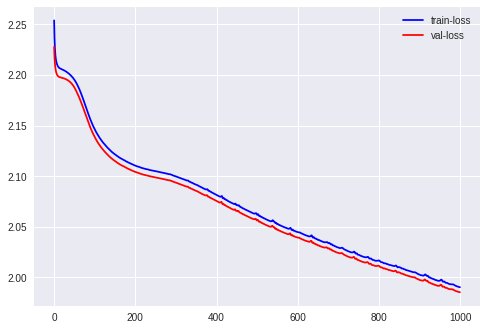

In [25]:
#train from all examples from train set
net.train((train_data-1).type(torch.float), (train_labels-1).type(torch.long), 
        epochs=1000,lr=0.1,verbose=100,
        val_data = (val_data-1).type(torch.float), 
        val_labels=(val_labels-1).type(torch.long)) 

In [27]:
input = test_data[1][:]
print(input.reshape(9,9))
output = net(input.type(torch.float)).reshape(81, 9)
print(output.max(1)[1].reshape(9,9) + 1)
target = test_labels[1][:]
print(target.reshape(9,9))

tensor([[2., 0., 6., 0., 0., 4., 0., 9., 8.],
        [0., 9., 0., 7., 0., 0., 3., 0., 6.],
        [8., 5., 0., 0., 1., 0., 0., 0., 0.],
        [3., 4., 0., 0., 7., 0., 0., 8., 1.],
        [0., 0., 5., 0., 0., 0., 7., 0., 0.],
        [7., 0., 8., 6., 0., 0., 0., 4., 5.],
        [0., 3., 0., 0., 2., 8., 9., 0., 4.],
        [0., 0., 2., 0., 0., 3., 0., 0., 0.],
        [1., 6., 0., 5., 0., 0., 0., 2., 0.]], device='cuda:0')
tensor([[3, 6, 8, 2, 9, 9, 9, 6, 7],
        [6, 6, 8, 1, 9, 9, 9, 6, 7],
        [6, 6, 8, 1, 9, 9, 9, 6, 7],
        [3, 6, 2, 4, 9, 9, 9, 6, 7],
        [9, 6, 8, 4, 9, 9, 2, 6, 7],
        [9, 6, 8, 4, 3, 9, 2, 6, 7],
        [8, 6, 8, 4, 3, 9, 2, 6, 7],
        [8, 6, 8, 4, 3, 9, 2, 6, 7],
        [8, 6, 8, 6, 3, 9, 2, 6, 7]], device='cuda:0')
tensor([[2., 7., 6., 3., 5., 4., 1., 9., 8.],
        [4., 9., 1., 7., 8., 2., 3., 5., 6.],
        [8., 5., 3., 9., 1., 6., 4., 7., 2.],
        [3., 4., 9., 2., 7., 5., 6., 8., 1.],
        [6., 2., 5., 8., 4., 1., 

In [0]:
bad = 0
for i in range(test_size):
  if net(test_data[i].type(torch.float))